# Solving the RB-Burgers model in 2D by finite differences

In [82]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline


# Global variables and discritization parameters
# time
Ttot = 80  
dt = 1.e-3
nt = int(Ttot/dt)+1
print("nt = "+str(nt))

#space
nx=200
nz=100
LX=2.01 
LZ=1.0 
dx=LX/(nx-1)
dz=LZ/(nz-1)

# control parameters
Ra = 10000
Pr = 1.0
const1 = np.sqrt(Pr/Ra)
const2 = 1./np.sqrt(Pr*Ra)

#grid
x = np.linspace(0, LX, nx)
z = np.linspace(0, LZ, nz)
Z,X = np.meshgrid(z,x)

#fields 
u = np.zeros((nx,nz))
v = np.zeros((nx,nz))
h = np.zeros((nx,nz))

nt = 80001


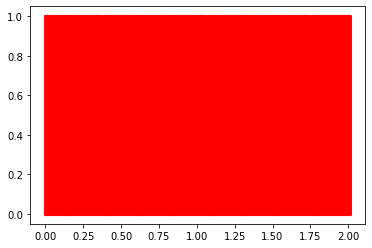

(200, 100)
(200, 100)
(200, 100)


In [56]:
# plot the grid
plt.scatter(X, Z, s=5, color='red', marker='o')
plt.show()
print(np.shape(X))
print(np.shape(Z))
print(np.shape(u))

In [83]:
# assigning initial conditions
seed=int(time.time())
np.random.seed(seed) #pick a random seed
for i in range(nx):
    for j in range(nz):
        u[i,j]=(2.*np.random.rand()-1.)*0.003 
        v[i,j]=(2.*np.random.rand()-1.)*0.003 
        h[i,j]=(2.*np.random.rand()-1.)*0.003 
        
# Velocity and temperature boundary conditions
u[:,0] = v[:,0 ] = h[:,0 ] = 0
u[:,nz-1] = v[:,nz-1] = h[:,nz-1] = 0

# Set zero mode to zero
u = u-np.mean(u)*np.ones((nx,nz))
v = v-np.mean(v)*np.ones((nx,nz))
h = h-np.mean(h)*np.ones((nx,nz))

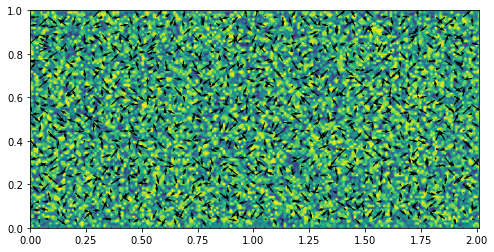

In [14]:
# plot the initial condition
fig = plt.figure(figsize = (LX*4, LZ*4))

plt.contourf(X,Z,h, levels=np.linspace(np.min(h),np.max(h),20)) 
# Plotting stream plot
#plt.streamplot(X,Z,u,v, density = 1., color="white")
step = 4
plt.quiver(X[::step,::step], Z[::step,::step], u[::step,::step], v[::step,::step])
    
# show plot
plt.show()

In [ ]:
# simple algorithm
un = np.zeros((nx,nz))
vn = np.zeros((nx,nz))
hn = np.zeros((nx,nz))

dt_over_dx = (dt/dx)
dt_over_dx2 = dt/(dx**2)
dt_over_dz = (dt/dz)
dt_over_dz2 = dt/(dz**2)

# loop across number of time steps
for n in range(nt):
    un = u.copy()
    vn = v.copy()
    hn = h.copy()

    # Faster algorithm
    unmx=np.roll(u, 1,axis=0)
    unmz=np.roll(u, 1,axis=1)
    unpx=np.roll(u,-1,axis=0)
    unpz=np.roll(u,-1,axis=1)
    
    vnmx=np.roll(v, 1,axis=0)
    vnmz=np.roll(v, 1,axis=1)
    vnpx=np.roll(v,-1,axis=0)
    vnpz=np.roll(v,-1,axis=1)
    
    hnmx=np.roll(h, 1,axis=0)
    hnmz=np.roll(h, 1,axis=1)
    hnpx=np.roll(h,-1,axis=0)
    hnpz=np.roll(h,-1,axis=1)
    
    u = un - (un * dt_over_dx * (un - unmx)) - (vn * dt_over_dz * (un - unmz)) + \
    const1*(dt_over_dx2*(unpx-2*un+unmx) + dt_over_dz2*(unpz-2*un+unmz))  
    
    v = vn - (un * dt_over_dx * (vn - vnmx)) - (vn * dt_over_dz * (vn - vnmz)) + \
    const1*(dt_over_dx2*(vnpx-2*vn+vnmx) + dt_over_dz2*(vnpz-2*vn+vnmz)) +\
    (dt*hn)
    
    h = hn - (un * dt_over_dx * (hn - hnmx)) - (vn * dt_over_dz * (hn - hnmz)) + \
    const2*(dt_over_dx2*(hnpx-2*hn+hnmx) + dt_over_dz2*(hnpz-2*hn+hnmz)) +\
    (dt*vn)
    
    # Set zero mode to zero
    u = u-np.mean(u)*np.ones((nx,nz))
    v = v-np.mean(v)*np.ones((nx,nz))
    h = h-np.mean(h)*np.ones((nx,nz))
    
    # Velocity and temperature boundary conditions
    u[:,0] = v[:,0 ] = h[:,0 ] = 0
    u[:,nz-1] = v[:,nz-1] = h[:,nz-1] = 0

## Improved algorithm
- first order upwind scheme for the advection
- 2nd order Adams-Bashforth for time stepping

In [84]:
# constants
invdx  = 1.0/dx
invdx2 = 1.0/dx**2
invdz  = 1.0/dz
invdz2 = 1.0/dz**2

# function to compute the rhs terms
def rhs(u,v,h):
    
    # Faster algorithm
    umx=np.roll(u, 1,axis=0)
    umz=np.roll(u, 1,axis=1)
    upx=np.roll(u,-1,axis=0)
    upz=np.roll(u,-1,axis=1)
    
    vmx=np.roll(v, 1,axis=0)
    vmz=np.roll(v, 1,axis=1)
    vpx=np.roll(v,-1,axis=0)
    vpz=np.roll(v,-1,axis=1)
    
    hmx=np.roll(h, 1,axis=0)
    hmz=np.roll(h, 1,axis=1)
    hpx=np.roll(h,-1,axis=0)
    hpz=np.roll(h,-1,axis=1)
    
    #upwind scheme
    up = np.maximum(u,0)
    um = np.minimum(u,0)
    udxu = invdx * (up*(u - umx) + um*(upx - u) )
    udxv = invdx * (up*(v - vmx) + um*(vpx - v) )
    udxh = invdx * (up*(h - hmx) + um*(hpx - h) )
    
    vp = np.maximum(v,0)
    vm = np.minimum(v,0)
    vdzu = invdz * (vp*(u - umz) + vm*(upz - u) )
    vdzv = invdz * (vp*(v - vmz) + vm*(vpz - v) )
    vdzh = invdz * (vp*(h - hmz) + vm*(hpz - h) )

    ru = - (udxu) - (vdzu) + \
    const1*(invdx2*(upx-2*u+umx) + invdz2*(upz-2*u+umz))  
    
    rv = - (udxv) - (vdzv) + \
    const1*(invdx2*(vpx-2*v+vmx) + invdz2*(vpz-2*v+vmz)) + h
    
    rh = - (udxh) - (vdzh) + \
    const2*(invdx2*(hpx-2*h+hmx) + invdz2*(hpz-2*h+hmz)) + v
    
    
    #not upwind
    """ 
    ru = - (u * invdx * (u - umx)) - (v * invdz * (u - umz)) + \
    const1*(invdx2*(upx-2*u+umx) + invdz2*(upz-2*u+umz))  
    
    rv = - (u * invdx * (v - vmx)) - (v * invdz * (v - vmz)) + \
    const1*(invdx2*(vpx-2*v+vmx) + invdz2*(vpz-2*v+vmz)) + h
    
    rh = - (u * invdx * (h - hmx)) - (v * invdz * (h - hmz)) + \
    const2*(invdx2*(hpx-2*h+hmx) + invdz2*(hpz-2*h+hmz)) + v
    """
    
    return ru, rv , rh
     
# define rhs fields     
rhs_u = np.zeros((nx,nz))
rhs_v = np.zeros((nx,nz))
rhs_h = np.zeros((nx,nz))

old_rhs_u = np.zeros((nx,nz))
old_rhs_v = np.zeros((nx,nz))
old_rhs_h = np.zeros((nx,nz))
    
one = np.ones((nx,nz))

vt = np.zeros(nt)
nu_real_bot = np.zeros(nt)
nu_real_top = np.zeros(nt)
#nu_real2 = np.zeros(nt)

# main loop on time
for n in range(nt):
    
    if n*dt%10==0:
        print("time = "+str(n*dt))
    
    old_rhs_u, old_rhs_v, old_rhs_h  = rhs_u, rhs_v, rhs_h
    rhs_u, rhs_v, rhs_h = rhs(u,v,h)
    # AB2
    u = u + dt*(1.5*rhs_u-0.5*old_rhs_u)
    v = v + dt*(1.5*rhs_v-0.5*old_rhs_v)
    h = h + dt*(1.5*rhs_h-0.5*old_rhs_h)
    
    # Velocity and temperature boundary conditions on horizontal lines
    u[:,0] = v[:,0 ] = h[:,0 ] = 0
    u[:,nz-1] = v[:,nz-1] = h[:,nz-1] = 0
    
    # Velocity and temperature boundary conditions on vertical lines
    #u[0,:] = v[0,:] = 0
    #u[nx-1,:] = v[nx-1,:] = 0
    #h[0,:] = h[nx-1,:]
    
    
    # Set zero mode to zero
    u = u-np.mean(u)*one
    v = v-np.mean(v)*one
    h = h-np.mean(h)*one
    
    # various diagnostics 
    vt[n] = np.mean(v*h)
    # first order fd of first derivative :
    #[ f(x+∆x) - f(x) ] / ∆x
    #nu_real[n] = 1 - invdz * ( np.mean(h[:,1]) - np.mean(h[:,0]) )
    # second order fd of first derivative : 
    #[ −3f(x)+4f(x+∆x)−f(x+2∆x) ] /(2∆x)
    nu_real_bot[n] = 1 - 0.5*invdz*(-3*np.mean(h[:,0])+4*np.mean(h[:,1])-np.mean(h[:,2]))
    # 3f(x)−4f(x−∆x)+f(x−2∆x)/(2∆x)
    nu_real_top[n] = 1 - 0.5*invdz*\
    ( 3*np.mean(h[:,nz-1])-4*np.mean(h[:,nz-2])+np.mean(h[:,nz-3]))

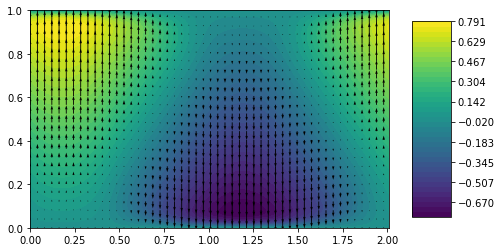

In [90]:
fig = plt.figure(figsize = (LX*4, LZ*4))
 
ax = plt.contourf(X,Z,h, levels=np.linspace(np.min(h),np.max(h),40)) 
# Plotting stream plot
#plt.streamplot(X,Z,u,v, density = 1., color="white")
# Plotting stream plot
step = 4
plt.quiver(X[::step,::step], Z[::step,::step], u[::step,::step], v[::step,::step])
plt.colorbar(ax, shrink=0.9, aspect=5)

# show plot
plt.show()

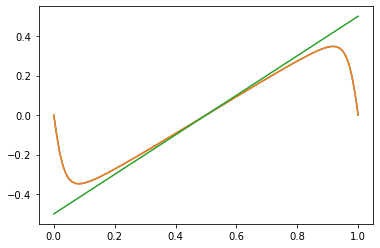

In [91]:
plt.plot(z,np.mean(v,axis=0))
plt.plot(z,np.mean(h,axis=0))
plt.plot(z, z-0.5)
plt.show()

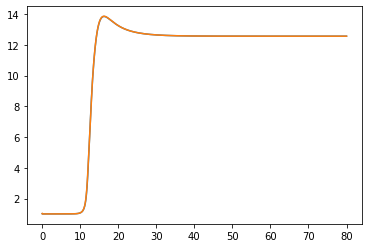

In [92]:
time = np.linspace(0,Ttot,nt)
#plt.plot(time,vt)
plt.plot(time,nu_real_top)
plt.plot(time,nu_real_bot)
plt.show()

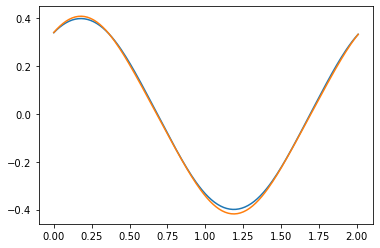

In [93]:
plt.plot(x,np.mean(v,axis=1))
plt.plot(x,v[:,int(nz/2)-1])
plt.show()

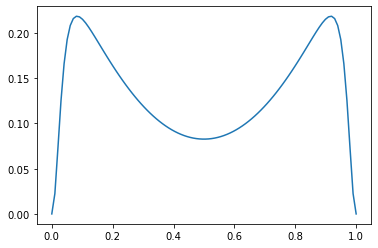

In [94]:
plt.plot(z,np.mean(v*h,axis=0))
plt.show()

# 1D reduction, for comparison

In [694]:
# assigning initial conditions
seed=int(time.time())
np.random.seed(seed) #pick a random seed
for j in range(nz):
    u[:,j]=(2.*np.random.rand()-1.)*0.003 
    v[:,j]=(2.*np.random.rand()-1.)*0.003 
    h[:,j]=(2.*np.random.rand()-1.)*0.003 
        
# Velocity and temperature boundary conditions
u[:,0] = v[:,0 ] = h[:,0 ] = 0
u[:,nz-1] = v[:,nz-1] = h[:,nz-1] = 0

# Set zero mode to zero
u = u-np.mean(u)*np.ones((nx,nz))
v = v-np.mean(v)*np.ones((nx,nz))
h = h-np.mean(h)*np.ones((nx,nz))

# constants--> this makes the simulation 1D
invdx  = 0.0
invdx2 = 0.0
invdz  = 1.0/dz
invdz2 = 1.0/dz**2


# function to compute the rhs terms
def rhs(u,v,h):
    
    # Faster algorithm
    umx=np.roll(u, 1,axis=0)
    umz=np.roll(u, 1,axis=1)
    upx=np.roll(u,-1,axis=0)
    upz=np.roll(u,-1,axis=1)
    
    vmx=np.roll(v, 1,axis=0)
    vmz=np.roll(v, 1,axis=1)
    vpx=np.roll(v,-1,axis=0)
    vpz=np.roll(v,-1,axis=1)
    
    hmx=np.roll(h, 1,axis=0)
    hmz=np.roll(h, 1,axis=1)
    hpx=np.roll(h,-1,axis=0)
    hpz=np.roll(h,-1,axis=1)
    
    #upwind scheme
    up = np.maximum(u,0)
    um = np.minimum(u,0)
    udxu = invdx * (up*(u - umx) + um*(upx - u) )
    udxv = invdx * (up*(v - vmx) + um*(vpx - v) )
    udxh = invdx * (up*(h - hmx) + um*(hpx - h) )
    
    vp = np.maximum(v,0)
    vm = np.minimum(v,0)
    vdzu = invdz * (vp*(u - umz) + vm*(upz - u) )
    vdzv = invdz * (vp*(v - vmz) + vm*(vpz - v) )
    vdzh = invdz * (vp*(h - hmz) + vm*(hpz - h) )

    ru = - (udxu) - (vdzu) + \
    const1*(invdx2*(upx-2*u+umx) + invdz2*(upz-2*u+umz))  
    
    rv = - (udxv) - (vdzv) + \
    const1*(invdx2*(vpx-2*v+vmx) + invdz2*(vpz-2*v+vmz)) + h
    
    rh = - (udxh) - (vdzh) + \
    const2*(invdx2*(hpx-2*h+hmx) + invdz2*(hpz-2*h+hmz)) + v
    
    
    #not upwind
    """ 
    ru = - (u * invdx * (u - umx)) - (v * invdz * (u - umz)) + \
    const1*(invdx2*(upx-2*u+umx) + invdz2*(upz-2*u+umz))  
    
    rv = - (u * invdx * (v - vmx)) - (v * invdz * (v - vmz)) + \
    const1*(invdx2*(vpx-2*v+vmx) + invdz2*(vpz-2*v+vmz)) + h
    
    rh = - (u * invdx * (h - hmx)) - (v * invdz * (h - hmz)) + \
    const2*(invdx2*(hpx-2*h+hmx) + invdz2*(hpz-2*h+hmz)) + v
    """
    
    return ru, rv , rh
     
# define rhs fields     
rhs_u = np.zeros((nx,nz))
rhs_v = np.zeros((nx,nz))
rhs_h = np.zeros((nx,nz))

old_rhs_u = np.zeros((nx,nz))
old_rhs_v = np.zeros((nx,nz))
old_rhs_h = np.zeros((nx,nz))
    
one = np.ones((nx,nz))

vt = np.zeros(nt)
nu_real_bot = np.zeros(nt)
nu_real_top = np.zeros(nt)
#nu_real2 = np.zeros(nt)

# main loop on time
for n in range(nt):
    
    old_rhs_u, old_rhs_v, old_rhs_h  = rhs_u, rhs_v, rhs_h
    rhs_u, rhs_v, rhs_h = rhs(u,v,h)
    # AB2
    u = u + dt*(1.5*rhs_u-0.5*old_rhs_u)
    v = v + dt*(1.5*rhs_v-0.5*old_rhs_v)
    h = h + dt*(1.5*rhs_h-0.5*old_rhs_h)
    
    # Velocity and temperature boundary conditions
    u[:,0] = v[:,0 ] = h[:,0 ] = 0
    u[:,nz-1] = v[:,nz-1] = h[:,nz-1] = 0
    
    # Set zero mode to zero
    u = u-np.mean(u)*one
    v = v-np.mean(v)*one
    h = h-np.mean(h)*one
    
    # various diagnostics 
    vt[n] = np.mean(v*h)
    # first order fd of first derivative :
    #[ f(x+∆x) - f(x) ] / ∆x
    #nu_real[n] = 1 - invdz * ( np.mean(h[:,1]) - np.mean(h[:,0]) )
    # second order fd of first derivative : 
    #[ −3f(x)+4f(x+∆x)−f(x+2∆x) ] /(2∆x)
    nu_real_bot[n] = 1 - 0.5*invdz*(-3*np.mean(h[:,0])+4*np.mean(h[:,1])-np.mean(h[:,2]))
    # 3f(x)−4f(x−∆x)+f(x−2∆x)/(2∆x)
    nu_real_top[n] = 1 - 0.5*invdz*\
    ( 3*np.mean(h[:,nz-1])-4*np.mean(h[:,nz-2])+np.mean(h[:,nz-3]))